In [211]:
import pandas as pd
from matplotlib import pylab
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBRegressor,plot_importance
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
from sklearn.model_selection import RandomizedSearchCV,learning_curve
from sklearn.ensemble import RandomForestRegressor
from numpy import absolute
from sklearn.preprocessing import LabelEncoder

In [212]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [213]:
dataset = pd.read_csv ('totaldata.csv')
norm_data = NormalizeData(dataset)
norm_data = pd.DataFrame(norm_data, columns=dataset.columns, index=dataset.index)

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'


In [214]:
Y = norm_data['outcome']
X = norm_data.iloc[:, 2:16]
X = X.loc[:, ~X.columns.isin(['height_m','albumin_g_d_l','initial_resp_rate','initial_temp_f','initial_diastolic_blood_pressure_mm_hg'])]


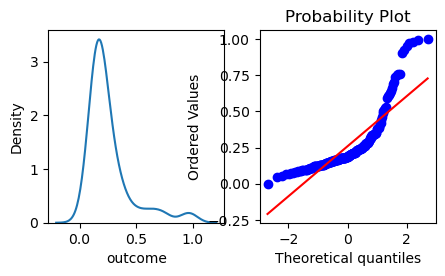

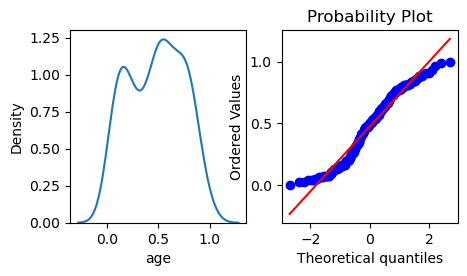

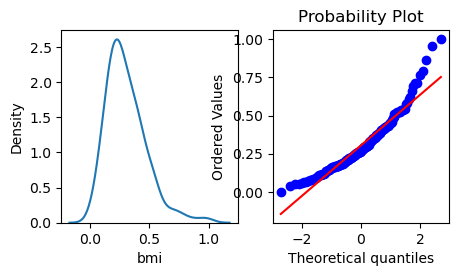

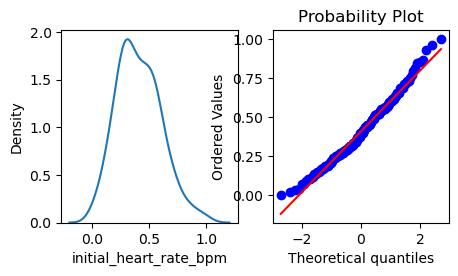

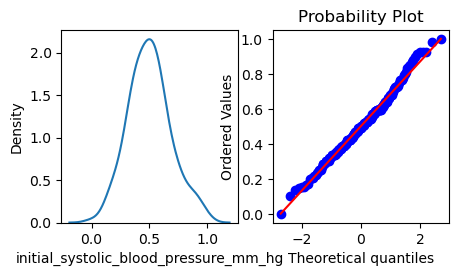

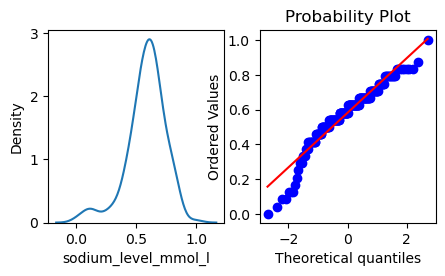

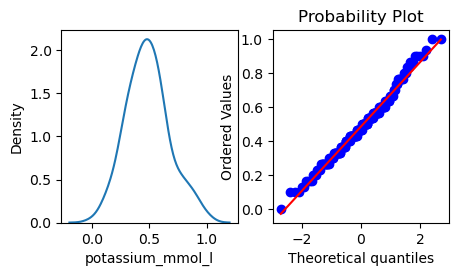

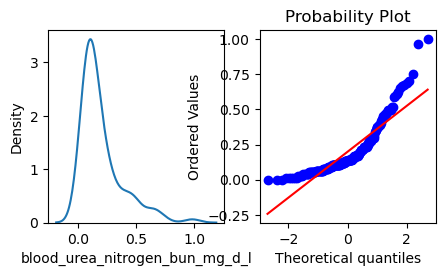

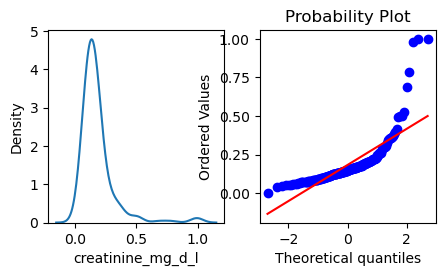

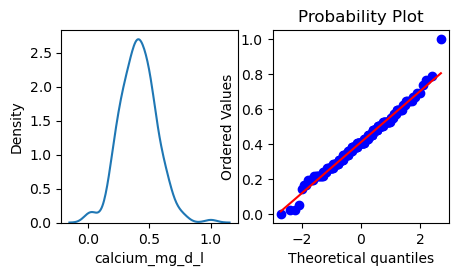

In [215]:
#function to return plots for the feature
column_names = list(X)

def normality(data,feature):
    plt.figure(figsize=(5,2.5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

normality(norm_data,'outcome')    
for i in column_names:
    normality(X,i)    

In [216]:
# split data into train and test sets
seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [217]:
#Best tuning the model

params = { 'max_depth': [1, 2, 3, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50],
           'reg_alpha': np.arange(0.000001,1,0.001),
           'reg_lambda':np.arange(0.000001,1,0.001),
           'learning_rate': np.arange(0.001,1,0.01),
           'subsample': np.arange(0.1, 1.0, 0.1),
           'colsample_bytree': np.arange(0.1, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.1, 1.0, 0.1),
           'n_estimators': np.arange(50,1000,50)}
xgbr = xgb.XGBRegressor(seed=42)
model = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)

model.fit(X_train, y_train)
print("Best parameters:", model.best_params_)
print("Lowest RMSE in Train: ", (-model.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.43500099999999997, 'reg_alpha': 0.862001, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.071, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.1}
Lowest RMSE in Train:  0.19088598768197418


In [218]:
#TRAIN
y_predTest = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_predTest))
print("Mean of TRAIN: % s "  % (np.mean(y_train)))
print("Standard Deviation of TRAIN: % s " % (np.std(y_train)))
print("Mean of Predicted: % s " % (np.mean(y_predTest)))
print("Standard Deviation of Predicted: % s " % np.std(y_predTest))
print("Mean Absolute Error in TRAIN: % s " % mean_absolute_error(y_train, y_predTest))
print("RMSE in TRAIN: %f" % (rmse))

Mean of TRAIN: 0.26535194174757326 
Standard Deviation of TRAIN: 0.20916281499874145 
Mean of Predicted: 0.26617405 
Standard Deviation of Predicted: 0.10520246 
Mean Absolute Error in TRAIN: 0.0996468596500991 
RMSE in TRAIN: 0.142324


In [219]:
#TEST
y_predTest = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predTest))
print("Mean of TEST: % s "  % (np.mean(y_test)))
print("Standard Deviation of TEST: % s " % (np.std(y_test)))
print("Mean of Predicted: % s " % (np.mean(y_predTest)))
print("Standard Deviation of Predicted: % s " % np.std(y_predTest))
print("Mean Absolute Error in TEST: % s " % mean_absolute_error(y_test, y_predTest))
print("RMSE in TEST: %f" % (rmse))

Mean of TEST: 0.23503236245954734 
Standard Deviation of TEST: 0.14540019005475563 
Mean of Predicted: 0.26124686 
Standard Deviation of Predicted: 0.06757481 
Mean Absolute Error in TEST: 0.11082196491242977 
RMSE in TEST: 0.157098


In [221]:
# real value
y_pred = model.predict(X_test)
expected = list(y_test)
# predicted value
predicted = list(y_pred)
# calculate errors
errors_test = list()
for i in range(len(expected)):
    # calculate error
    err = (expected[i] - predicted[i])**2
    # store error
    errors_test.append(err)
    # report error
   #print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))

In [222]:
# real value
y_predd = model.predict(X_train)
expected = list(y_train)
# predicted value
predicted = list(y_predd)
# calculate errors
errors_train = list()
for i in range(len(expected)):
    # calculate error
    err = (expected[i] - predicted[i])**2
    # store error
    errors_train.append(err)
    # report error
   #print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))

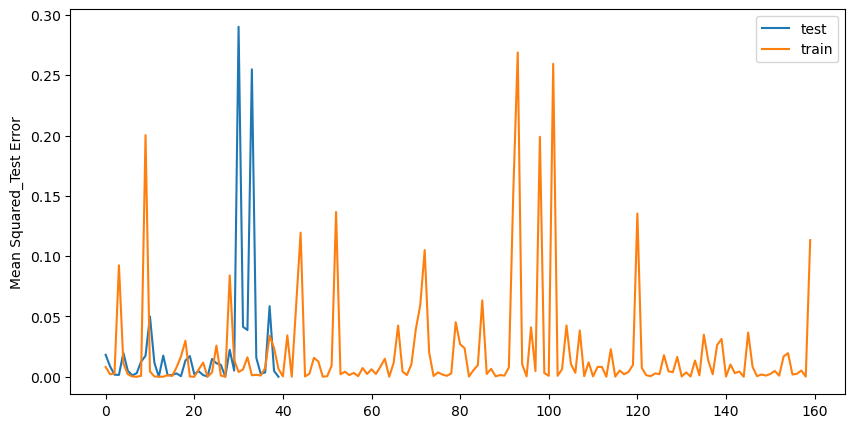

In [223]:
# plot errors
plt.figure(figsize=(10,5))
plt.plot(errors_test,label='test')
plt.plot(errors_train,label='train')
plt.xlabel('')
plt.ylabel('Mean Squared_Test Error')
plt.legend()
plt.show()

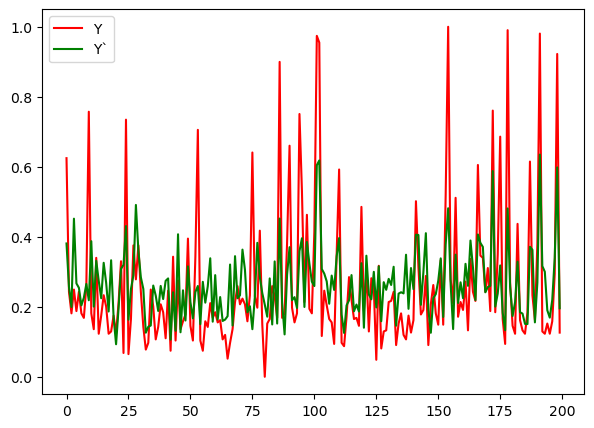

In [224]:
yhat = model.predict(X)
plt.figure(figsize=(7,5))
plt.plot(Y, color='r', label='Y')
plt.plot(yhat, color='g', label='Y`')
  
plt.legend()
plt.show()

In [225]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.1, colsample_bynode=1,
             colsample_bytree=0.30000000000000004, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.071, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.862001,
             reg_lambda=0.43500099999999997, ...)

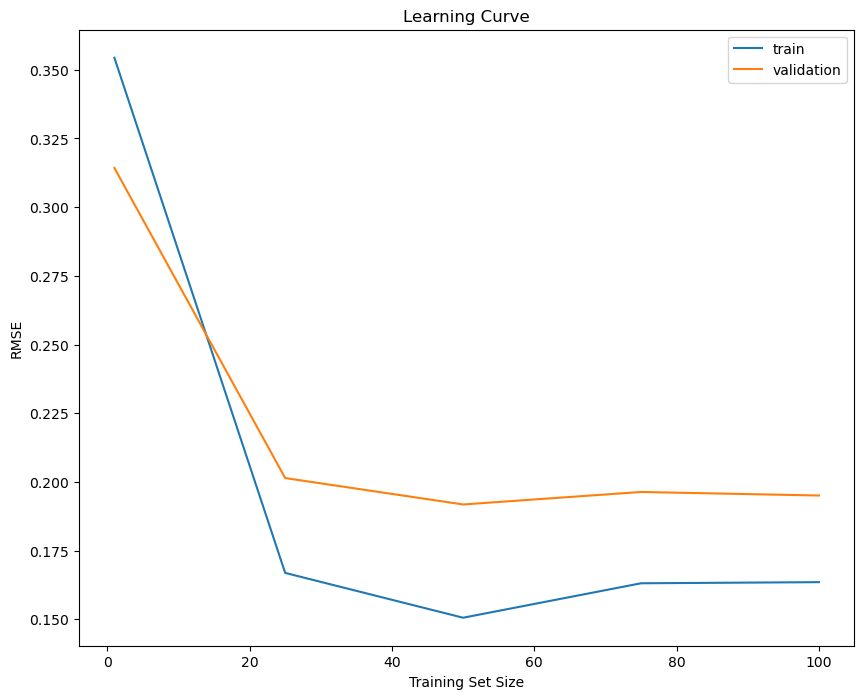

In [250]:
xgbooster = xgb.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.1, colsample_bynode=1,
             colsample_bytree=0.30000000000000004, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.071, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=np.nan, monotone_constraints='()',
             n_estimators=60, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.862001,seed=42)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgbooster,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [1, 25, 50, 75, 100]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.show()

In [251]:
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
xgbooster.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset)

[0]	validation_0-rmse:0.30125	validation_1-rmse:0.28912
[1]	validation_0-rmse:0.28969	validation_1-rmse:0.27556
[2]	validation_0-rmse:0.27967	validation_1-rmse:0.26475
[3]	validation_0-rmse:0.26961	validation_1-rmse:0.25481
[4]	validation_0-rmse:0.26147	validation_1-rmse:0.24458
[5]	validation_0-rmse:0.25258	validation_1-rmse:0.23495
[6]	validation_0-rmse:0.24543	validation_1-rmse:0.22801
[7]	validation_0-rmse:0.23878	validation_1-rmse:0.21986
[8]	validation_0-rmse:0.23239	validation_1-rmse:0.21196
[9]	validation_0-rmse:0.22662	validation_1-rmse:0.20554
[10]	validation_0-rmse:0.22227	validation_1-rmse:0.20068
[11]	validation_0-rmse:0.21739	validation_1-rmse:0.19451
[12]	validation_0-rmse:0.21364	validation_1-rmse:0.18981
[13]	validation_0-rmse:0.20944	validation_1-rmse:0.18511
[14]	validation_0-rmse:0.20553	validation_1-rmse:0.18156
[15]	validation_0-rmse:0.20278	validation_1-rmse:0.17773
[16]	validation_0-rmse:0.20048	validation_1-rmse:0.17458
[17]	validation_0-rmse:0.19809	validation

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.1, colsample_bynode=1,
             colsample_bytree=0.30000000000000004, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.071, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.862001, reg_lambda=1, ...)

In [252]:
results = xgbooster.evals_result()

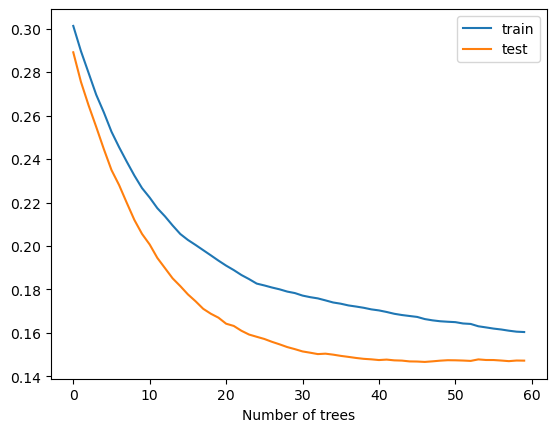

In [253]:
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.xlabel('Number of trees')
plt.legend()
# show the plot
plt.show()

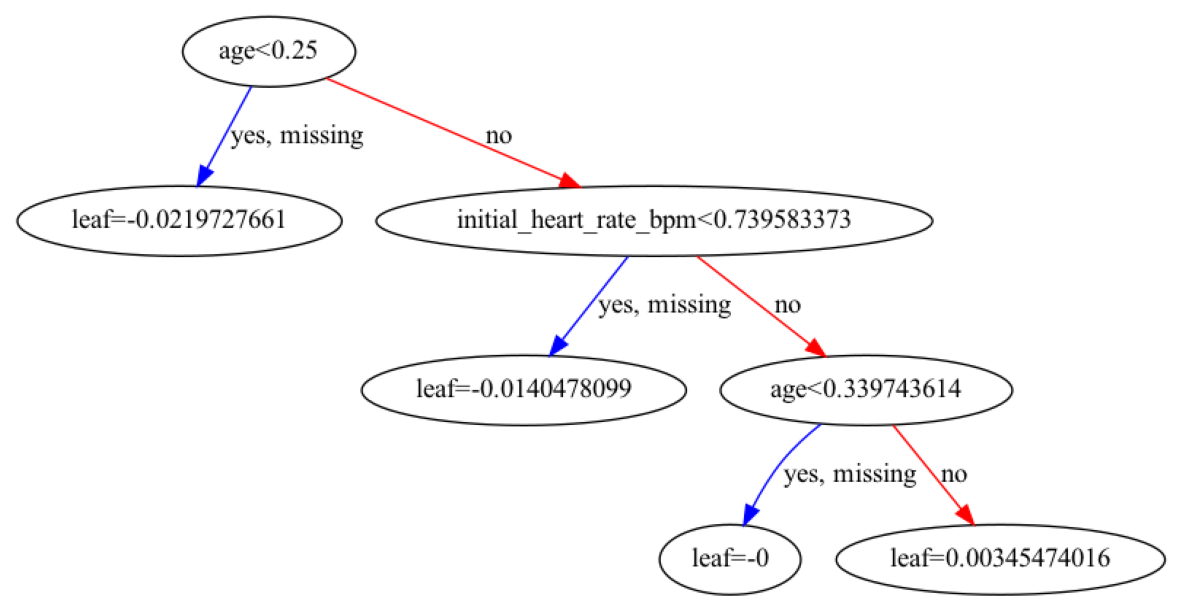

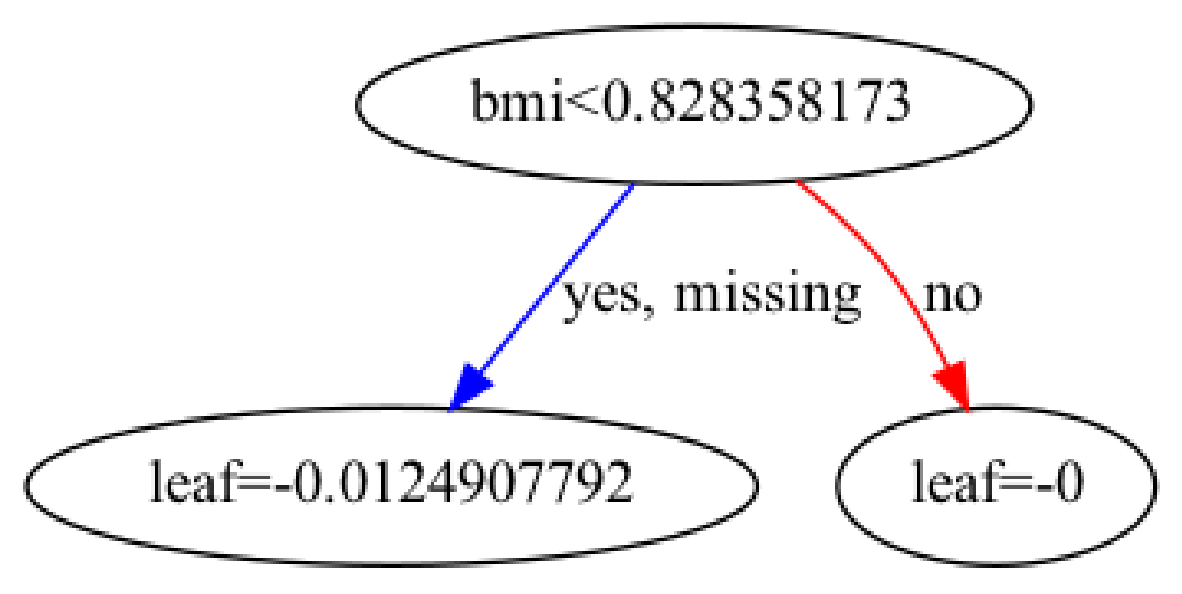

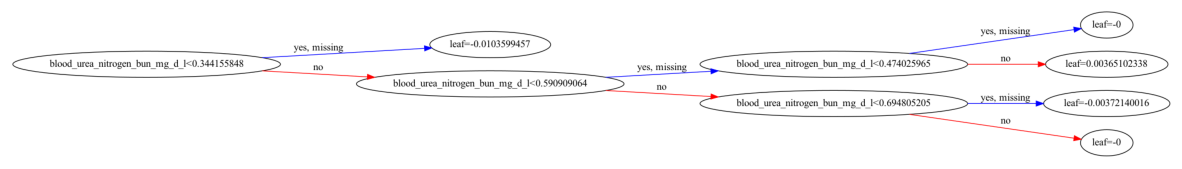

In [230]:
# Visualizing individual XGBoost trees

# Plot the first tree
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgbooster, num_trees=0, ax=ax);

# Plot the fifth tree
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgbooster, num_trees=4, ax=ax);

# Plot the last tree sideways
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xgbooster, rankdir="LR", num_trees=9, ax=ax);

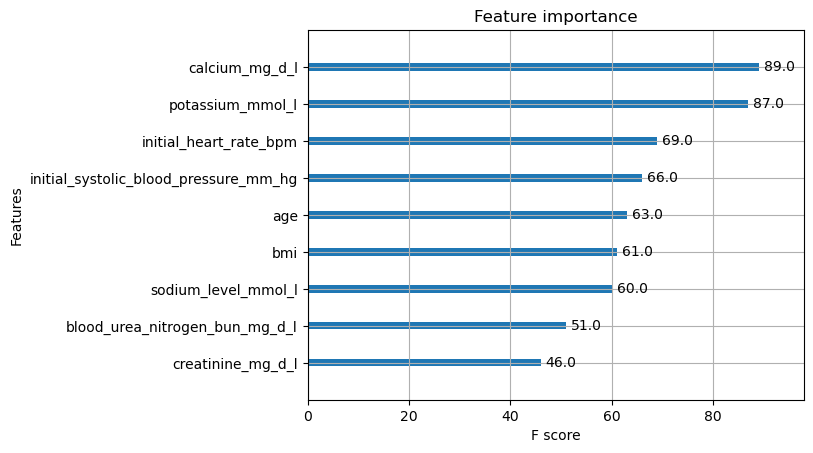

In [231]:
plot_importance(xgbooster)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


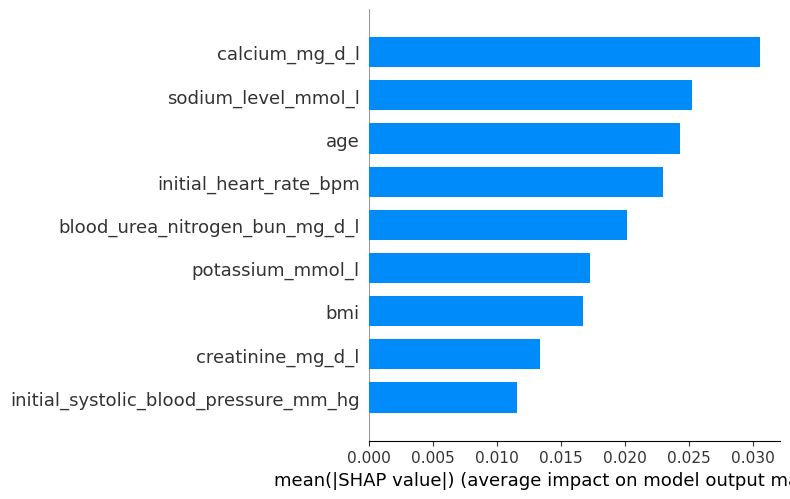

In [232]:
import shap
explainer = shap.TreeExplainer(xgbooster)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [233]:
feature_importances = pd.Series(xgbooster.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False)

blood_urea_nitrogen_bun_mg_d_l           0.207094
calcium_mg_d_l                           0.186948
initial_heart_rate_bpm                   0.115712
potassium_mmol_l                         0.097957
bmi                                      0.087087
sodium_level_mmol_l                      0.086208
age                                      0.081622
creatinine_mg_d_l                        0.078653
initial_systolic_blood_pressure_mm_hg    0.058720
dtype: float32

# Random Forest model

In [234]:
# split data into train and test sets
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [235]:
#Best tuning the model

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [236]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/ahmedshaheen/miniforge3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [238]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

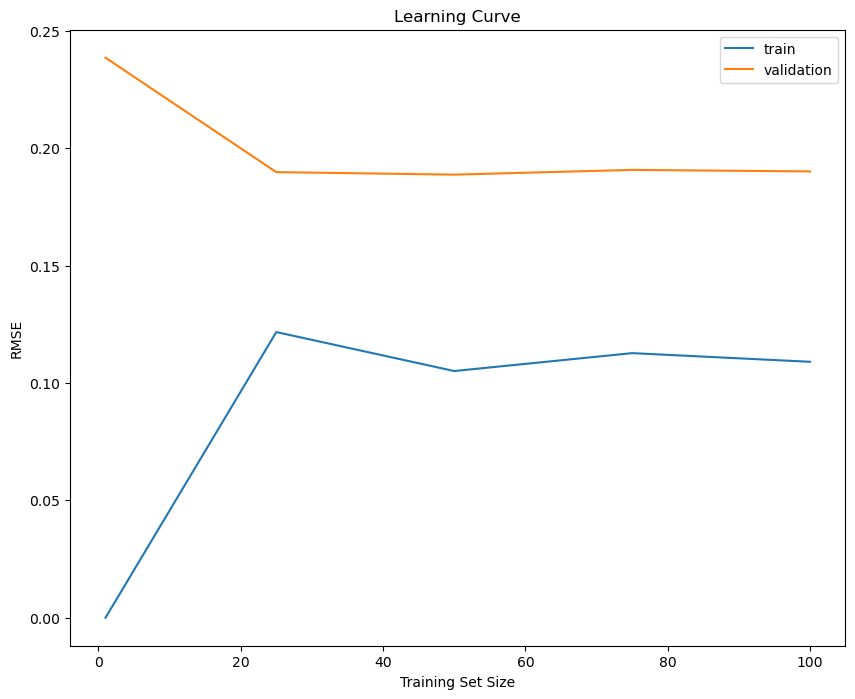

In [239]:
random_forest =  RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=1200,bootstrap=True,min_samples_split=2)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=random_forest,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes = [1, 25, 50, 75, 100]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.show()

In [240]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=1200)

In [241]:
# real value
y_pred = random_forest.predict(X_test)
expected = list(y_test)
# predicted value
predicted = list(y_pred)
# calculate errors
errors_test = list()
for i in range(len(expected)):
    # calculate error
    err = (expected[i] - predicted[i])**2
    # store error
    errors_test.append(err)

In [242]:
# real value
y_predd = random_forest.predict(X_train)
expected = list(y_train)
# predicted value
predicted = list(y_predd)
# calculate errors
errors_train = list()
for i in range(len(expected)):
    # calculate error
    err = (expected[i] - predicted[i])**2
    # store error
    errors_train.append(err)

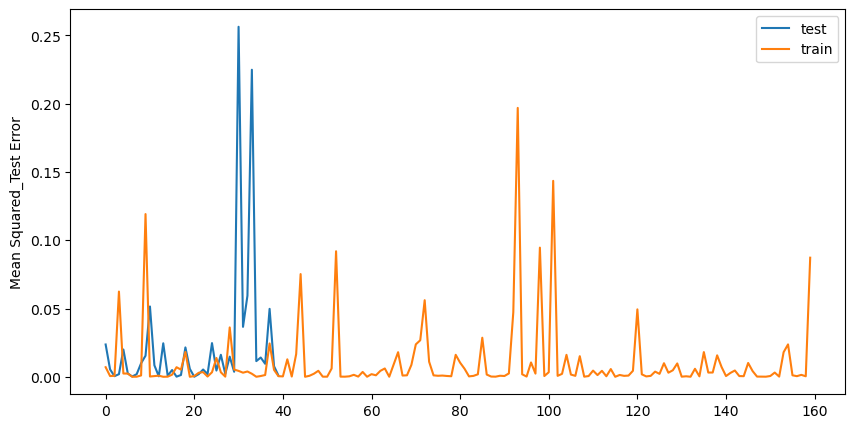

In [243]:
# plot errors
plt.figure(figsize=(10,5))
plt.plot(errors_test,label='test')
plt.plot(errors_train,label='train')
plt.xlabel('')
plt.ylabel('Mean Squared_Test Error')
plt.legend()
plt.show()

In [244]:
#TRAIN
y_predTest = random_forest.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_predTest))
print("Mean of TRAIN: % s "  % (np.mean(y_train)))
print("Standard Deviation of TRAIN: % s " % (np.std(y_train)))
print("Mean of Predicted: % s " % (np.mean(y_predTest)))
print("Standard Deviation of Predicted: % s " % np.std(y_predTest))
print("Mean Absolute Error in TRAIN: % s " % mean_absolute_error(y_train, y_predTest))
print("RMSE in TRAIN: %f" % (rmse))

Mean of TRAIN: 0.26535194174757326 
Standard Deviation of TRAIN: 0.20916281499874145 
Mean of Predicted: 0.2662552049352557 
Standard Deviation of Predicted: 0.1240900776523 
Mean Absolute Error in TRAIN: 0.06752387465381879 
RMSE in TRAIN: 0.101902


In [245]:
#TEST
y_predTest = random_forest.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predTest))
print("Mean of TEST: % s "  % (np.mean(y_test)))
print("Standard Deviation of TEST: % s " % (np.std(y_test)))
print("Mean of Predicted: % s " % (np.mean(y_predTest)))
print("Standard Deviation of Predicted: % s " % np.std(y_predTest))
print("Mean Absolute Error in TEST: % s " % mean_absolute_error(y_test, y_predTest))
print("RMSE in TEST: %f" % (rmse))

Mean of TEST: 0.23503236245954734 
Standard Deviation of TEST: 0.14540019005475563 
Mean of Predicted: 0.2627700011486929 
Standard Deviation of Predicted: 0.06369215824124042 
Mean Absolute Error in TEST: 0.11123495075357934 
RMSE in TEST: 0.153790


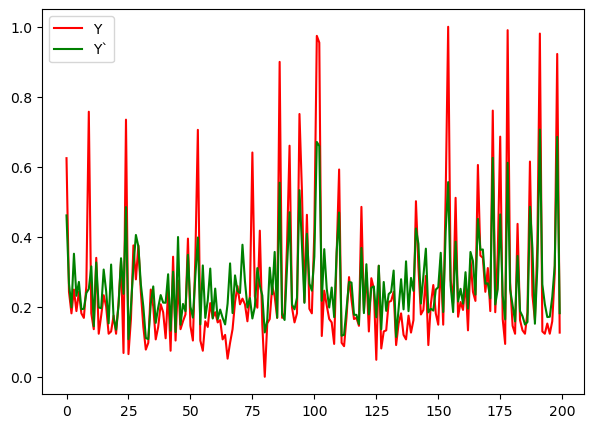

In [246]:
yhat = random_forest.predict(X)
plt.figure(figsize=(7,5))
plt.plot(Y, color='r', label='Y')
plt.plot(yhat, color='g', label='Y`')
  
plt.legend()
plt.show()

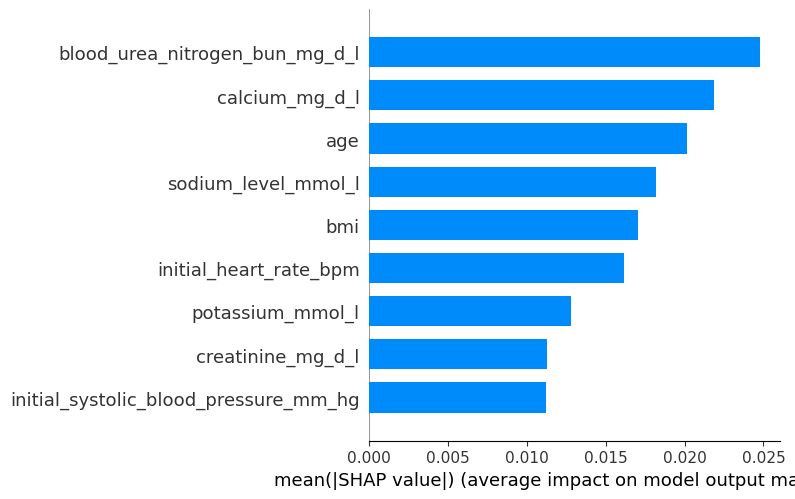

In [247]:
import shap
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [248]:
feature_importances = pd.Series(random_forest.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False)

calcium_mg_d_l                           0.144940
blood_urea_nitrogen_bun_mg_d_l           0.140590
initial_heart_rate_bpm                   0.113879
bmi                                      0.106719
age                                      0.105899
initial_systolic_blood_pressure_mm_hg    0.104683
creatinine_mg_d_l                        0.099409
sodium_level_mmol_l                      0.093002
potassium_mmol_l                         0.090880
dtype: float64